# Models

## Common Code

Common functions for training and fine-tuning the BERT models.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print("INIT module_path: ", module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

DATA_DIR = module_path + "/data"
MODEL_DIR = module_path + "/model"

for data_dir in [DATA_DIR, MODEL_DIR]:
    os.makedirs(data_dir, exist_ok=True)

INIT module_path:  c:\Users\Alan\Desktop\Open_Source\BERT-TLSA-paper


In [2]:
from transformers import BertTokenizerFast, BertForMaskedLM, BertModel, BertConfig
import torch
import enum
from typing import cast

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class BERTSentimentClassifier(torch.nn.Module):
    def __init__(self, bert: BertModel):
        super().__init__()
        self.bert = bert
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(bert.config.hidden_size, 1), # Convert from the hidden state to a single output
            torch.nn.Sigmoid() # Constrain output between 0 and 1
        )
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, expected_score: torch.FloatTensor, *args, **kwargs) -> dict:
        bert_output = self.bert(*args, **kwargs)
        # https://huggingface.co/transformers/v3.2.0/model_doc/bert.html
        # Pooler output is last layer of hidden state for [CLS] token, whose
        # output is fed through a linear layer and a tanh function
        #
        # Shape of (batch_size, hidden_size) 
        output: torch.FloatTensor = self.linear(bert_output.pooler_output).squeeze()
        loss = self.loss_fn(output, expected_score)
        return {
            "norm_score": output,
            "loss": loss,
        }
    

def bucketize_norm_scores(norm_scores: torch.FloatTensor, max_score: int) -> torch.IntTensor:
    """
    Convert norm_scores into specific numbers
    """
    return norm_scores // max_score


class TrainingConfig:
    def __init__(self, tokenizer: BertTokenizerFast, model: BertForMaskedLM, stop_delta_loss: float = 0.01, epoch_window: int = 5, name: str = "model"):
        self.tokenizer = tokenizer
        self.model = model
        self.name = name
        # We stop when the average delta loss <= stop_delta_loss
        # This average is taken over a window of size epoch_window 
        self.stop_delta_loss = stop_delta_loss
        # Number of epochs from now to the past used to calculate the average delta loss
        self.epoch_window = epoch_window
        # The final classifier model, after finetuning
        self.finetuned_classifier_model = cast(BERTSentimentClassifier, None)

    def __str__(self):
        return str(self.__dict__)
    
    def __repr__(self):
        return str(self)


def build_training_config(pretrained_model: bool = False, pretrained_model_name: str = "bert-base-uncased", stop_delta_loss: float = 0.01, epoch_window: int = 5, name: str = "model") -> TrainingConfig:
    # NOTE: We are not re-training a tokenizer, since it's out of the scope of this experiment
    tokenizer: BertTokenizerFast = BertTokenizerFast.from_pretrained(pretrained_model_name)
    if pretrained_model:
        # Create tokenizer + already trained model
        model: BertForMaskedLM = BertForMaskedLM.from_pretrained(pretrained_model_name)
    else:
        config = BertConfig(
            vocab_size=tokenizer.vocab_size,
            max_position_embeddings=512,
            hidden_size=256,
            num_hidden_layers=4,
            num_attention_heads=4,
            type_vocab_size=2
        )
        model: BertForMaskedLM = BertForMaskedLM(config)
    # Move the model to the device we speicified
    #   Ideally use CUDA (GPU) if available
    model.to(device)
    return TrainingConfig(tokenizer=tokenizer, model=model, stop_delta_loss=stop_delta_loss, epoch_window=epoch_window, name=name)

print(f"Training on device: {device}")

Training on device: cuda


In [3]:
from transformers import BertTokenizerFast
import pandas as pd
import torch
from typing import TypedDict, cast
import numpy as np


def move_dict_to(res: dict, device: torch.device):
    for key in res:
        if isinstance(res[key], torch.Tensor):
            res[key] = cast(torch.Tensor, res[key]).to(device=device)


class TokenizedInputs(TypedDict):
    input_ids: torch.IntTensor
    token_type_ids: torch.IntTensor
    attention_mask: torch.IntTensor
    labels: torch.IntTensor


class MaskedTextDatasetItem(TokenizedInputs):
    original_text: str


class MaskedTextDataset(torch.utils.data.Dataset[MaskedTextDatasetItem]):
    """
    Dataset of masked text
    """
    def __init__(self, encodings: TokenizedInputs, original_text: list[str] = None, batch_device: torch.device = None):
        self.encodings = encodings
        self.original_text = original_text
        self.batch_device = batch_device

    def __getitem__(self, index: int) -> MaskedTextDatasetItem:
        # Return the dictionary just like encodings, except it only
        # contains the entries for a specific row (sentence)
        res = {key: val[index] for key, val in self.encodings.items() }
        if self.original_text:
            res["original_text"] = self.original_text[index]
        # If output_device is set, we move individual batches to the device
        if self.batch_device:
            move_dict_to(res, self.batch_device)
        return res
    
    def __len__(self):
        return len(self.encodings["input_ids"])
    
    def to(self, device: torch.device):
        # NOTE: Moving entire dataset to GPU memory is a bad idea -- we don't have a lot of GPU memory
        move_dict_to(self.encodings, device)


class ReviewsDatasetItem(TokenizedInputs):
    original_text: str
    norm_score: float
    score: int
    max_score: int


class ReviewsDataset(torch.utils.data.Dataset[ReviewsDatasetItem]):
    """
    Dataset of reviews and their normaliezd scores (decimal number from 0 to 1)
    """
    def __init__(self, encodings: TokenizedInputs, scores: list[int], max_score: int, original_text: list[str] = None, batch_device: torch.device = None):
        self.encodings = encodings
        self.scores = scores
        self.max_score = max_score
        self.original_text = original_text
        self.batch_device = batch_device
    
    def __getitem__(self, index: int) -> ReviewsDatasetItem:
        # Return the dictionary just like encodings, except it only
        # contains the entries for a specific row (sentence)
        res = {key: val[index] for key, val in self.encodings.items() }
        if self.original_text:
            res["original_text"] = self.original_text[index]
        res["norm_score"] = float(self.scores[index]) / self.max_score
        res["score"] = self.scores[index]
        res["max_score"] = self.max_score
        # If output_device is set, we move individual batches to the device
        if self.batch_device:
            move_dict_to(res, self.batch_device)
        return res

    def __len__(self):
        return len(self.encodings["input_ids"])
    
    def to(self, device: torch.device):
        # NOTE: Moving entire dataset to GPU memory is a bad idea -- we don't have a lot of GPU memory
        move_dict_to(self.encodings, device)


def get_masked_dataset(tokenizer: BertTokenizerFast, review_texts: list[str], percent_masked: float = 0.15, dataset_file: str = "", batch_device: torch.device = None) -> MaskedTextDataset:
    print("Loading masked dataset:")
    if dataset_file:
        print(f"    Loading existing dataset file @ {dataset_file}...")
        # Check if dataset file exists — if so, then load from file
        try:
            # Disable weights_only since we are loading aribitrary python classes
            masked_text_dataset: MaskedTextDataset = torch.load(f"{DATA_DIR}/{dataset_file}", weights_only=False)
            return masked_text_dataset
        except Exception as e:
            print(f"    Error loading dataset file: {e}")
    print(f"    Creating new dataset file @ {dataset_file}...")
    encodings: TokenizedInputs = tokenizer(review_texts, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    # Create a new field labels that is a clone of input_ids
    encodings["labels"] = encodings["input_ids"].detach().clone()
    # In BERT paper, each token has 15% chance of being masked
    # First, create random vector that spans all of the input_ids (spans all the tokens)
    rand = torch.rand(encodings["input_ids"].shape)
    # (rand < 0.15) -> Any token that has a corresponding random value of < 0.15, we mask
    # We also don't want to mask special tokens (101, 102), and padding tokens (0)
    # * operator is elementwise multiplication, which is same as AND for boolean tensors
    mask_arr = (rand < percent_masked) * (encodings["input_ids"] != 101) * (encodings["input_ids"] != 0) * (encodings["input_ids"] != 102)
    # Stores all the indices that we want to mask
    masked_cols = []
    # Iterate over each row in the mask_arr (basically each sentence in our text data)
    for i in range(mask_arr.shape[0]):
        # .nonzero() -> finds the indicies where we have "true" values (since true = 1 and false = 0 in pytorch)
        masked_cols.append(mask_arr[i].nonzero().flatten().tolist())
    # Apply our mask_arr in each row (each sentence)
    for i in range(mask_arr.shape[0]):
        # Special Tensor syntax -> we can pass in a list of indicies for any of the axes
        #   In this case, we pass in a list of indices in the column axis, to effectively
        #   select the columns (tokens) we want to mask out
        encodings["input_ids"][i, masked_cols[i]] = 103
    masked_text_dataset = MaskedTextDataset(encodings, review_texts, batch_device=batch_device)
    if dataset_file:
        torch.save(masked_text_dataset, f"{DATA_DIR}/{dataset_file}")
    return masked_text_dataset


def get_reviews_dataset(tokenizer: BertTokenizerFast, review_scores: list[float], max_score: int, review_texts: list[str], dataset_file: str = "", batch_device: torch.device = None) -> ReviewsDataset:
    print("Loading reviews dataset:")
    if dataset_file:
        print(f"    Loading existing dataset file @ {dataset_file}...")
        # Check if dataset file exists — if so, then load from file
        try:
            # Disable weights_only since we are loading aribitrary python classes
            reviews_dataset: ReviewsDataset = torch.load(f"{DATA_DIR}/{dataset_file}", weights_only=False)
            return reviews_dataset
        except Exception as e:
            print(f"    Error loading dataset file: {e}")
    encodings: TokenizedInputs = tokenizer(review_texts, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    reviews_dataset = ReviewsDataset(encodings, review_scores, max_score, review_texts, batch_device=batch_device)
    print(f"    Creating new dataset file @ {dataset_file}...")
    if dataset_file:
        torch.save(reviews_dataset, f"{DATA_DIR}/{dataset_file}")
    return reviews_dataset

In [4]:
from IPython.display import clear_output
from tqdm import tqdm
from transformers.modeling_outputs import MaskedLMOutput
from typing import cast, Iterator
import matplotlib.pyplot as plt
import itertools
from collections import deque
from typing import TypeVar, Generic
import torch.utils.data as tdata
import sklearn.model_selection as skms
import math
import copy
import torch
from typing import Callable
import numpy as np


TDataset = TypeVar('TDataset', bound=tdata.Dataset)
class TrainDatasetSplit(Generic[TDataset]):
    def __init__(self, train: tdata.Subset[TDataset], test: tdata.Subset[TDataset], valid: tdata.Subset[TDataset]):
        self.train = train
        self.test = test
        self.valid = valid
    
    def get_dataloaders(self, batch_size: int = None, shuffle: bool = None, drop_last: bool = False) -> tuple[tdata.DataLoader, tdata.DataLoader, tdata.DataLoader]:
        return (tdata.DataLoader(self.train, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last), \
                tdata.DataLoader(self.test, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last), \
                tdata.DataLoader(self.valid, shuffle=shuffle, batch_size=batch_size, drop_last=drop_last))


def train_split_dataset(dataset: TDataset, train_percent: float = 0.7, test_percent: float = 0.2, validate_percent: float = 0.1, random_state: int = None) -> TrainDatasetSplit[TDataset]:
    assert math.isclose(train_percent + test_percent + validate_percent, 1.0), "Expected train_percent + test_percent + validate_percent = 1.0!"
    dataset_indices = list(range(len(dataset)))
    test_train_indices, valid_indicies = skms.train_test_split(dataset_indices, test_size=validate_percent, random_state=random_state)
    train_indicies, test_indicies = skms.train_test_split(test_train_indices, test_size=test_percent/(train_percent + test_percent), random_state=random_state)
    valid = tdata.Subset(dataset, valid_indicies)
    train = tdata.Subset(dataset, train_indicies)
    test = tdata.Subset(dataset, test_indicies)
    split = TrainDatasetSplit(train=train, test=test, valid=valid)
    return split


def get_newest_model_file(prefix: str) -> str:
    idx = -1
    while os.path.exists(f"{prefix}{idx + 1}.pt"):
        idx += 1
    if idx >= 0:
        return f"{prefix}{idx}.pt"
    return ""


class TrainLoopIterData:
    is_valid: bool

    output_loss: torch.FloatTensor
    output_num_correct: int

    def reset(self, is_valid: bool = False):
        self.output_loss = None
        self.output_num_correct = None
        self.is_valid = is_valid
    
    def postfix(self) -> dict:
        return {
            "loss": self.output_loss.item(),
            "num_correct": self.output_num_correct
        }


class TrainLoopStats:
    def __init__(self):
        self.reset()

    def reset(self):
        self.total_loss = cast(float, None)
        self.total_correct = cast(int, None)
        self.average_loss = cast(float, 0)
        self.accuracy = cast(float, 0)
    
    def add_iter_data(self, output: TrainLoopIterData):
        if output.output_loss:
            if self.total_loss == None:
                self.total_loss = 0
            self.total_loss += output.output_loss.item()
        if output.output_num_correct:
            if self.total_correct == None:
                self.total_correct = 0
            self.total_correct += output.output_num_correct

    def calculate(self, batch_count: int, items_count: int):
        self.average_loss = self.total_loss / batch_count if self.total_loss else None
        self.accuracy = self.total_correct / items_count if self.total_correct else None


TDatasetItem = TypeVar('TItem')
TModel = TypeVar('TModel', bound=torch.nn.Module)
def train_loop(name: str, desc: str, model_prefix: str, train_dataloader: tdata.DataLoader[TDatasetItem], valid_dataloader: tdata.DataLoader[TDatasetItem], model: TModel, optim: torch.optim.Optimizer, epoch_window: int, stop_delta_loss: float, train_fn: Callable[[TModel, TDatasetItem, TrainLoopIterData], None]):
    log_data: list[dict] = []
    init_epoch = 0
    prev_average_valid_loss: float = None
    
    model_dir = f"{MODEL_DIR}/{name}/"
    os.makedirs(model_dir, exist_ok=True)

    def calculate_delta_loss_moving_avg(log_data: list[dict]) -> float:
        if len(log_data) <= 1:
            return None
        if len(log_data) <= epoch_window:
            # Exclude the first entry if our window isn't large enough, since
            # the first entry does not have a valid_loss_delta, as deltas
            # are only calculated between entries.
            log_data = log_data[1:]
        return np.average([x["valid_loss_delta"] for x in log_data[-epoch_window:]])

    existing_model_file = get_newest_model_file(model_dir + model_prefix)
    if existing_model_file:
        # If model file exist, then try to continue off of where it left off
        data = torch.load(existing_model_file)
        model.load_state_dict(data["model"])
        optim.load_state_dict(data["optim"])
        init_epoch = data["log_data"][-1]["epoch"] + 1
        log_data = data["log_data"]
        prev_average_valid_loss = log_data[-1]["valid_loss"]
        print("")
        delta_loss_moving_avg = calculate_delta_loss_moving_avg(log_data)
        print(f"Resuming existing model at epoch: {init_epoch}, valid loss: {log_data[-1]["valid_loss"]}, delta_loss: {delta_loss_moving_avg} <= {-stop_delta_loss}")
        if delta_loss_moving_avg != None and -delta_loss_moving_avg <= stop_delta_loss:
            # We hit the cutoff, return early
            return
        # Otherwise, continue training

    print(f"Training start for '{name}' {desc}...")
    loop_iter_data = TrainLoopIterData()
    epoch_loop = itertools.count(start=init_epoch, step=1)
    for epoch in epoch_loop:
        # Training loop
        loop = tqdm(cast(Iterator[MaskedTextDatasetItem], train_dataloader), leave=True)
        train_stats = TrainLoopStats()
        loss_delta = None

        model.train()
        for data in loop:
            loop_iter_data.reset(is_valid=False)

            # Reset gradient
            optim.zero_grad()

            train_fn(model, data, loop_iter_data)
            loss = loop_iter_data.output_loss
            
            # Apply backward propagation
            loss.backward()
            optim.step()

            # Set info in tqdm progress bar
            loop.set_description(f"Epoch: {epoch}")
            loop.set_postfix(loop_iter_data.postfix())
            train_stats.add_iter_data(loop_iter_data)
        train_stats.calculate(batch_count=len(train_dataloader), items_count=len(train_dataloader.dataset))

        print(f"Average training loss: {train_stats.average_loss}")

        # Validation loop
        loop = tqdm(cast(Iterator[MaskedTextDatasetItem], valid_dataloader), leave=True)
        valid_stats = TrainLoopStats()
        model.eval()
        with torch.no_grad():
            for data in loop:
                loop_iter_data.reset(is_valid=True)

                train_fn(model, data, loop_iter_data)
                loss = loop_iter_data.output_loss

                # Set info in tqdm progress bar
                loop.set_postfix(loop_iter_data.postfix())
                valid_stats.add_iter_data(loop_iter_data)
        valid_stats.calculate(batch_count=len(valid_dataloader), items_count=len(valid_dataloader.dataset))

        print(f"Average validation loss: {valid_stats.average_loss}")

        # Update moving average of validation loss
        if prev_average_valid_loss != None:
            loss_delta = valid_stats.average_loss - prev_average_valid_loss
        else:
            loss_delta = None
        prev_average_valid_loss = valid_stats.average_loss

        # Make plot
        log_data_entry = {
            "epoch": epoch,
            "train_loss": train_stats.average_loss,
            "valid_loss": valid_stats.average_loss,
        }
        if valid_stats.accuracy:
            log_data_entry["valid_accuracy"] = valid_stats.accuracy
        if loss_delta != None:
            log_data_entry["valid_loss_delta"] = loss_delta
        log_data.append(log_data_entry)
        delta_loss_moving_avg = calculate_delta_loss_moving_avg(log_data)

        epochs = [x["epoch"] for x in log_data]
        for key in log_data[0]:
            if key.startswith("_") or key == "epoch":
                continue
            plt.plot(epochs, [item[key] for item in log_data], label=key)
        clear_output(wait=True)
        plt.legend()
        plt.show()

        if epoch % 10 == 0:
            torch.save({
                "model": model.state_dict(),
                "optim": optim.state_dict(),
                "log_data": log_data,
            }, model_dir + model_prefix + f"{epoch}.pt")

        # Break if our moving validation delta loss average is smaller than our stop_delta_loss
        print(f"Average delta loss ({epoch_window} epoch window): {delta_loss_moving_avg} <= {-stop_delta_loss}")
        if delta_loss_moving_avg != None and -delta_loss_moving_avg <= stop_delta_loss:
            break


def pretraining_loop(train_dataloader: tdata.DataLoader[MaskedTextDatasetItem], valid_dataloader: tdata.DataLoader[MaskedTextDatasetItem], config: TrainingConfig):
    def train_fn(model: BertForMaskedLM, data: MaskedTextDatasetItem, iter_data: TrainLoopIterData) -> torch.FloatTensor:
        outputs: MaskedLMOutput = model(input_ids=data["input_ids"].to(device), attention_mask=data["attention_mask"].to(device), labels=data["labels"].to(device))
        iter_data.output_loss = outputs.loss
    
    model = config.model
    optim = torch.optim.AdamW(model.parameters(), lr=1e-5)
    train_loop(name=config.name, 
        desc="pretraining",
        model_prefix="model_pretrain_",
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        model=model,
        optim=optim,
        epoch_window=config.epoch_window,
        stop_delta_loss=config.stop_delta_loss,
        train_fn=train_fn)


def finetuning_loop(train_dataloader: tdata.DataLoader[ReviewsDatasetItem], valid_dataloader: tdata.DataLoader[ReviewsDatasetItem], config: TrainingConfig):
    def train_fn(model: BERTSentimentClassifier, data: ReviewsDatasetItem, iter_data: TrainLoopIterData) -> torch.FloatTensor:
        output = model(input_ids=data["input_ids"].to(device), attention_mask=data["attention_mask"].to(device), expected_score=data["norm_score"].to(dtype=torch.float32, device=device))
        iter_data.output_loss = output["loss"]
        if iter_data.is_valid:
            # Track accuracy for validation set
            pred_score = bucketize_norm_scores(output["norm_score"].to(device), data["max_score"].to(device))
            correct_preds = torch.count_nonzero(pred_score == data["score"].to(device))
            iter_data.output_num_correct = correct_preds

    # Load data into a raw BERT model
    # We set strict=False, since the pooler bias and weights are not set
    bert_copy = BertModel.from_pretrained("bert-base-uncased") # BertModel(config.model.bert.config)
    
    # Freeze all parameters (except for pooler)
    for name, param in bert_copy.named_parameters():
        param.requires_grad = "pooler" in name

    # bert_copy.load_state_dict(config.model.bert.state_dict(), strict=False)
    model = BERTSentimentClassifier(bert_copy)
    model.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=1e-5)
    train_loop(name=config.name, 
        desc="finetuning",
        model_prefix="model_finetune_",
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        model=model,
        optim=optim,
        epoch_window=config.epoch_window,
        stop_delta_loss=config.stop_delta_loss,
        train_fn=train_fn)
    
    config.model.finetuned_classifier_model = model


def dataset_train_loop(dataset_name: str = "myanimelist") -> tuple[Callable[[], None], Callable[[float], None], Callable[[float], None]]:
    TEST_PERCENT = 0.7
    TRAIN_PERCENT = 0.2
    VALIDATE_PERCENT = 0.1
    BATCH_SIZE = 32

    data_df = pd.read_csv(f"{DATA_DIR}/{dataset_name}_reviews.csv")

    review_texts = data_df["review"].astype(str).to_list()
    review_scores = data_df["score"].astype(int).to_list()
    review_max_score: int = data_df.loc[0, "max_score"]
    
    print(f"Starting training for {dataset_name}...")
    print(f"    review_texts: {review_texts[:3]}")
    print(f"    review_scores: {review_scores[:3]}")
    print(f"    review_max_score: {review_max_score}")
    
    config: TrainingConfig = None
    
    def reset():
        nonlocal config
        config = build_training_config(name=dataset_name, stop_delta_loss=0.05, epoch_window=5)
    
    reset()
    print(f"Loaded training config:")
    display(config)
    
    masked_dataset = get_masked_dataset(config.tokenizer, review_texts, dataset_file=f"{dataset_name}_masked_data.dt")
    def pretraining(stop_delta_loss: float = 0.05):
        nonlocal config
        config.stop_delta_loss = stop_delta_loss
        reviews_split = train_split_dataset(masked_dataset, train_percent=TRAIN_PERCENT, test_percent=TEST_PERCENT, validate_percent=VALIDATE_PERCENT)
        train_reviews_dataloader, test_reviews_dataloader, valid_reviews_dataloader = reviews_split.get_dataloaders(batch_size=BATCH_SIZE, shuffle=True)
        print(f"Masked pretraining:")
        print(f"    train_dataloader: ({len(train_reviews_dataloader)} batches)\n    test_dataloader: ({len(test_reviews_dataloader)} batches)\n    valid_dataloader: ({len(valid_reviews_dataloader)} batches)")
        display(next(iter(train_reviews_dataloader)))
        pretraining_loop(train_reviews_dataloader, valid_reviews_dataloader, config)    

    reviews_dataset = get_reviews_dataset(config.tokenizer, review_scores, review_max_score, review_texts, dataset_file=f"{dataset_name}_reviews_data.dt")
    def finetuning(stop_delta_loss: float = 0.05):
        nonlocal config
        config.stop_delta_loss = stop_delta_loss
        reviews_split = train_split_dataset(reviews_dataset, train_percent=TRAIN_PERCENT, test_percent=TEST_PERCENT, validate_percent=VALIDATE_PERCENT)
        train_reviews_dataloader, test_reviews_dataloader, valid_reviews_dataloader = reviews_split.get_dataloaders(batch_size=BATCH_SIZE, shuffle=True)
        print(f"Reviews training:")
        print(f"    train_dataloader: ({len(train_reviews_dataloader)} batches)\n    test_dataloader: ({len(test_reviews_dataloader)} batches)\n    valid_dataloader: ({len(valid_reviews_dataloader)} batches)")
        display(next(iter(train_reviews_dataloader)))
        finetuning_loop(train_reviews_dataloader, valid_reviews_dataloader, config)

    return [reset, pretraining, finetuning]

## MyAnimeList

Training BERT on MyAnimeList only.

In [5]:
reset, pretraining, finetuning = dataset_train_loop("myanimelist")

Starting training for myanimelist...
    review_texts: ['Oh dear Shingeki no Kyojin, where do I even begin. If you\'ve talked with your friends about anime, then the couple anime that everyone talks about are Naruto, Bleach, One Piece, Dragon Ball, and... Shingeki no Kyojin. What\'s the difference between Shingeki and the rest? Shingeki only has 25 episodes so far yet it\'s on par in popularity with the other super long, Americanized anime. Why is it popular? Well that\'s simply because it\'s stunningly amazing. Those people that call Shingeki no Kyojin "overrated" may not have the same taste as me, and that\'s perfectly fine, but in my honest opinion, Shingeki no Kyojin isone of if not the greatest anime to be made. It\'s not popular for no reason.\n\nThe story is one of the most captivating stories I\'ve ever seen. 100 years prior to the start of the anime, humanity has been on the bridge of extinction due to the monstrous humanoid Titans that devour humans. Now, present day in the a

{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'model': BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embed

Loading masked dataset:
    Loading existing dataset file @ myanimelist_masked_data.dt...
Loading reviews dataset:
    Loading existing dataset file @ myanimelist_reviews_data.dt...


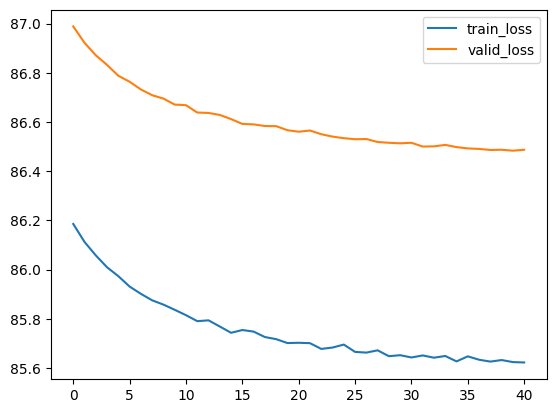

Average delta loss (5 epoch window): -0.0010693504696803302 <= 1000


  0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:
reset()
pretraining()
finetuning(-1000)

## Steam

Training BERT on Steam only.

In [ ]:
dataset_train_loop("steam")

Starting training for steam...
    review_texts: ["Amazing game. Easily 30-40 hours of game play. I hope the dev continues to add more depth in the future! I'd love to see,- More zones, cities, villages etc- Additional starting scenarios (in debt, being a dealer for someone else, certain supplies/drugs not available)- Setups (undercover cops/narcs)- Raids/counter-raids (Police/cartel)- Thief's stealing supplies (if door left open, or employees turning against you)- Mixing drugs with other drugs (weed w/ cocaine)- Turf wars w/ opponent drug-lord organisation charts that you can war with, slowly discover their hierarchy and order hits or do them yourself- High volume deals (shipping supplies off to other regions)", 'For a just "released in early access game" the devs managed to make a game that works, have a fun gameplay loop and satisfying pacing in growth. I would like to see:- a search function in the product management app- a way to change the strain\'s name after the fact, not only 

{'tokenizer': BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), 'model': BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embed

Loading masked dataset:
    Loading existing dataset file @ steam_masked_data.dt...
    Error loading dataset file: [Errno 2] No such file or directory: 'c:\\Users\\Alan\\Desktop\\Open_Source\\BERT-TLSA-paper/data/steam_masked_data.dt'
    Creating new dataset file @ steam_masked_data.dt...


## Metacritic

Training BERT on Metacritic only.

In [ ]:
dataset_train_loop("metacritic")

['Boring game that was soulless even in the beginning. Its contemporaries Roadblocks (why is this censored lol) and Blockland do everything better. Easily the most overrated game of all time.',
 'the best, the only, the unique game in its genre.\nThis game gave me my childhood, THIS IS THE BEST GAME',
 'Not my cup of tea due to so many choices. Still pretty great. Memorable style of world. Diverse & expansive gameplay. Major impact on the industry.',
 'Film He was Very average More I gave Credit By the References And also For the Nostalgia The jokes They are not Funny One Except Put Some well Specific More on al He was Good More or less',
 'Minecraft é muito criativo, dá muita liberdade para os jogadores, possui um vasto lore próprio, muitos detalhes, investimento e desenvolvimento contínuo ao longo de anos após o lançamento, meus amigo sempre gostaram, sempre foi muito popular no youtube e na twitch...\n\nE mesmo assim eu nunca gostei tanto. Talvez pelo gênero de sobrevivência que não

## Rotten Tomatoes

Training BERT on Rotten Tomatoes only.

In [ ]:
dataset_train_loop("rotten_tomatoes")

['Una obra de arte dirigida por Denis Villeneuve. Esta película es una de las mejores que he visto en este género. Sin necesidad de leer los libros, comprenderás a la perfección todo el contexto. El director busca deleitarnos con sus tomas cinematográficas y su espectacular sonido ambiental. Una obra de arte digna de un Oscar. El único problema que le veo, y por el que no le doy un 10, es el comienzo. Puede ser muy tedioso, pero se entiende perfectamente por qué.\n\nConclusión: Esta es una película que definitivamente tienes que ver en algún momento. El comienzo puede ser lento porque te da mucho contexto. No pierdas la oportunidad de verla.\n\nCalificación: 8.5/10',
 'Took me a while to get into it, but as someone who has not read the Dune books, it truly feels like a book. I can see the influence and see how the book must have been like, I definitely plan to read the books at some point. Some of the decisions are a bit sub-par though. They should 100% have had a different cast. Yes, 